In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from captum.attr import Occlusion
from captum.attr import visualization as viz

## Get Dataset Statistics

In [2]:
from utils.preprocessing import get_mean_std, get_label_map

split_ratio = [0.7, 0.15, 0.15]
mean, std = get_mean_std('dataset_1500', split_ratio=split_ratio, random_seed=2024)

label_map = get_label_map('dataset_1500')

Calculating mean and std: 100%|██████████| 99/99 [00:09<00:00, 10.81it/s]


## Load Pre-Trained Model

In [ ]:
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

model = models.efficientnet_v2_s()
print(model.classifier)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.BatchNorm1d(128),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 3)
)
print(model.classifier)

model.load_state_dict(torch.load('ckpts/effv2s_bn_si_0.001_10_0.5/best_val_acc.pth', map_location=device))
model.to(device)

## Image Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def process_image(image):
    return transform(image).unsqueeze(0)

In [5]:
# img = Image.open('assets/red-billed-blue-magpie.png')
# img = Image.open('assets/taiwan-blue-magpie.png')
img = Image.open('assets/yellow-billed-blue-magpie.png')

transformed_img = process_image(img)
print(transformed_img.shape)

torch.Size([1, 3, 256, 256])


## Predict

In [13]:
model.eval()
output = model(transformed_img.to(device))
output = F.softmax(output, dim=1)
prob, pred = torch.max(output, 1)

pred.squeeze_()
predicted_label = label_map[pred.item()]
print(f"Predicted_label: {predicted_label} | Probablity: {prob.item()}")

Predicted_label: yellow-billed-blue-magpie | Probablity: 0.9990444779396057


## Occlusion-based attribution

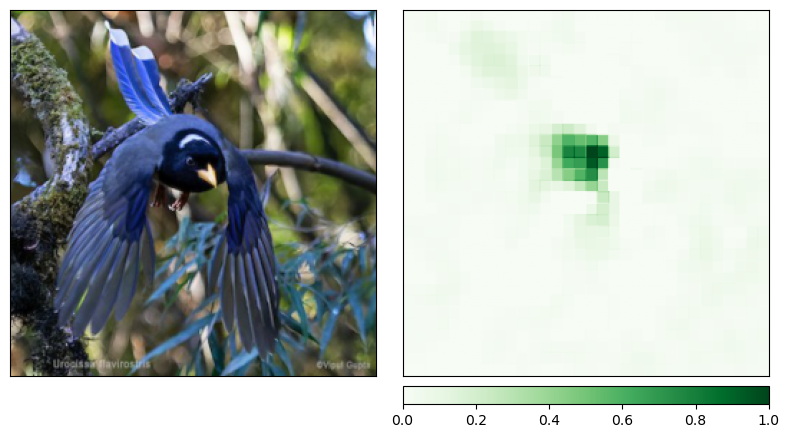

In [7]:
model.to(device)
model = model.eval()
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(transformed_img.to(device),
                                       strides = (3, 8, 8),
                                       target=pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(img),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

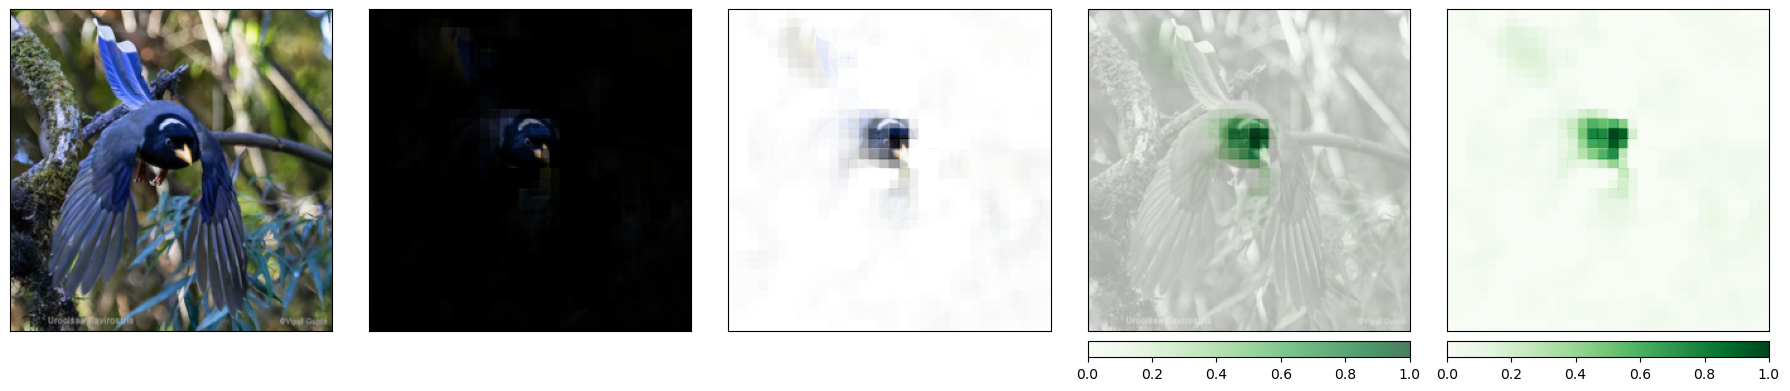

In [8]:
model.to(device)
model = model.eval()
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(transformed_img.to(device),
                                       strides = (3, 8, 8),
                                       target=pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(img.resize((256, 256))),
                                      ["original_image", "masked_image", "alpha_scaling", "blended_heat_map", "heat_map"],
                                      ["all", "positive", "positive", "positive", "positive"],
                                      fig_size=(18, 18),
                                      alpha_overlay=0.7,
                                      show_colorbar=True,
                                      outlier_perc=2)